# HMM

In [1]:
from hmmlearn import hmm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Define a function to train and plot an HMM

In [2]:
def train_and_plot_single(
    visible_sequence_train,
    visible_sequence_test, 
    n_components : int = 2, 
    plot : bool = True
    ) -> np.array:   
    # create and train an HMM model
    model = hmm.GaussianHMM(n_components=n_components)
    model.fit(visible_sequence_train)
    # predict the most likely sequence of internal hidden state
    prob, hidden_sequence = model.decode(visible_sequence_test, algorithm='viterbi')
    if plot:
        # transform the numpy matrix into a 1-D list
        visible_sequence_test = [i[0] for i in visible_sequence_test]
        colors_map = {0: "red", 1: "green", 2: "blue", 3: "yellow", 4: "orange", 5: "purple", 6: "pink", 7: "brown", 8: "gray", 9: "olive", 10: "cyan"}
        # map the hidden states to colors
        colors_sequence = [colors_map[i] for i in hidden_sequence]
        plt.subplots(figsize=(21, 9))
        # set the x axis label
        plt.xlabel('Samplings (10min intervals)')
        # set the y axis label
        plt.ylabel('Value')
        # set the title
        plt.title(f'HMM Model with {n_components} hidden states')
        plt.bar(
            x = [i for i in range(len(visible_sequence_test))],
            height = visible_sequence_test,
            color = colors_sequence
        )
        plt.show()
    return hidden_sequence, model

## Train, validation and test split

Since the values are sampled every 10 minutes, one day is represented by 144 points, one week by 1008 points and one month by 4320 points.

In [3]:
# get the column "Appliance" and "light" from the dataset
df = pd.read_csv("energydata_complete.csv", usecols=["Appliances", "lights"])

# trasfrorm the Appliances column into a numpy matrix
x_app = df["Appliances"].to_numpy().reshape(-1, 1)
x_light = df["lights"].to_numpy().reshape(-1, 1)

# split the x arrays in weeks, there are 19 weeks in the dataset
x_app = np.array_split(x_app, len(x_app) / 1008)
x_light = np.array_split(x_light, len(x_light) / 1008)

# the train set will be the first 7 weeks
train_set_app = x_app[:7]
train_set_light = x_light[:7]
train_set_app = np.concatenate(train_set_app)
train_set_light = np.concatenate(train_set_light)

# the validation set will be the subsequent 7 weeks
validation_set_app = x_app[7:14]
validation_set_light = x_light[7:14]
validation_set_app = np.concatenate(validation_set_app)
validation_set_light = np.concatenate(validation_set_light)

# the test set will the 5 middle weeks
test_set_app = x_app[14:19]
test_set_light = x_light[14:19]
test_set_app = np.concatenate(test_set_app)
test_set_light = np.concatenate(test_set_light)

## Appliances dataset

Training and plot the models starting from 2 up to 5 components.

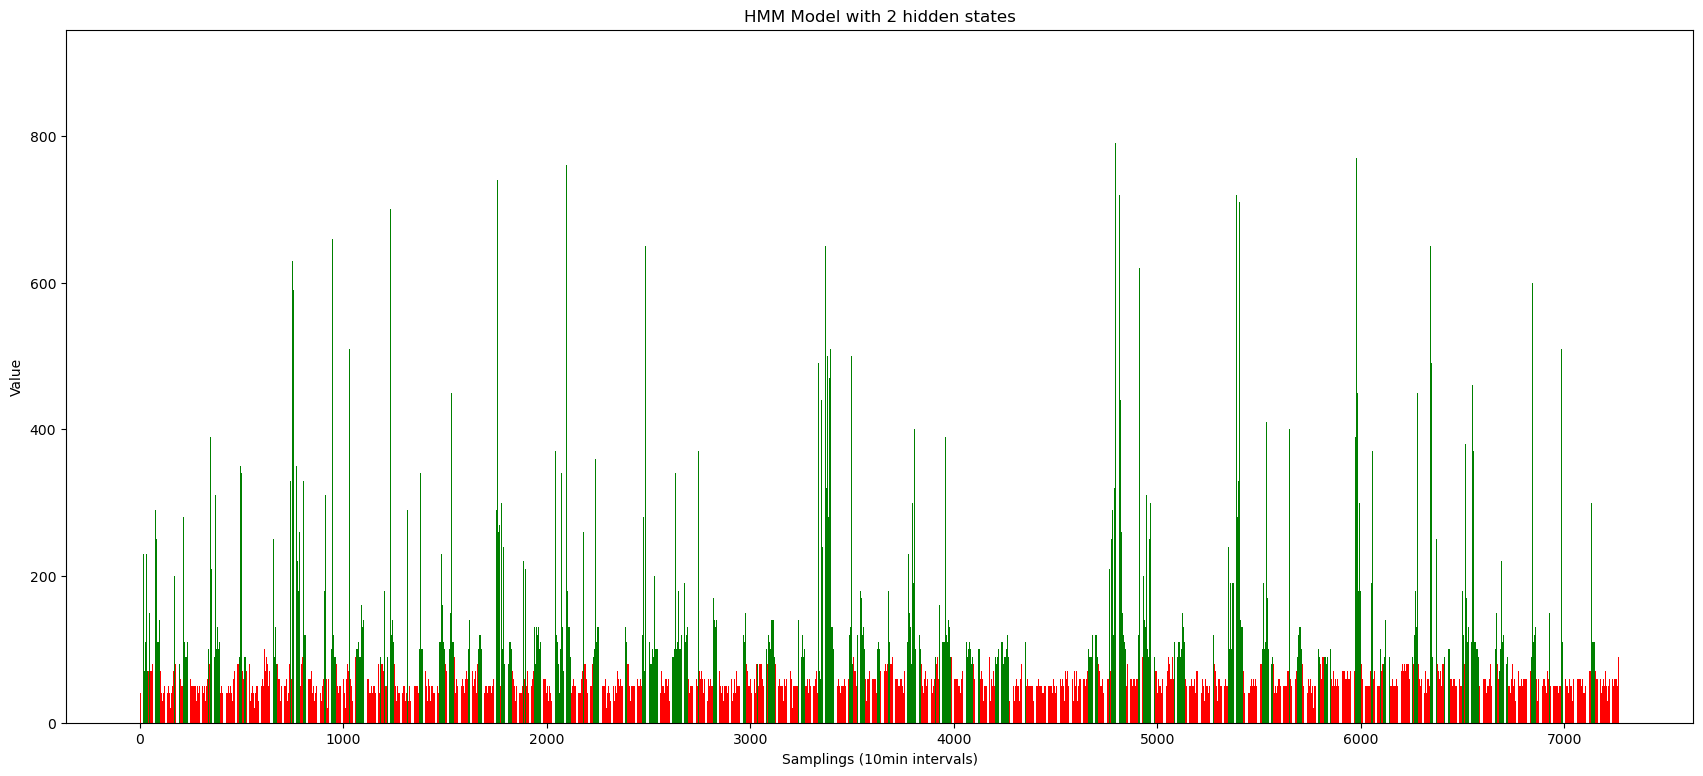

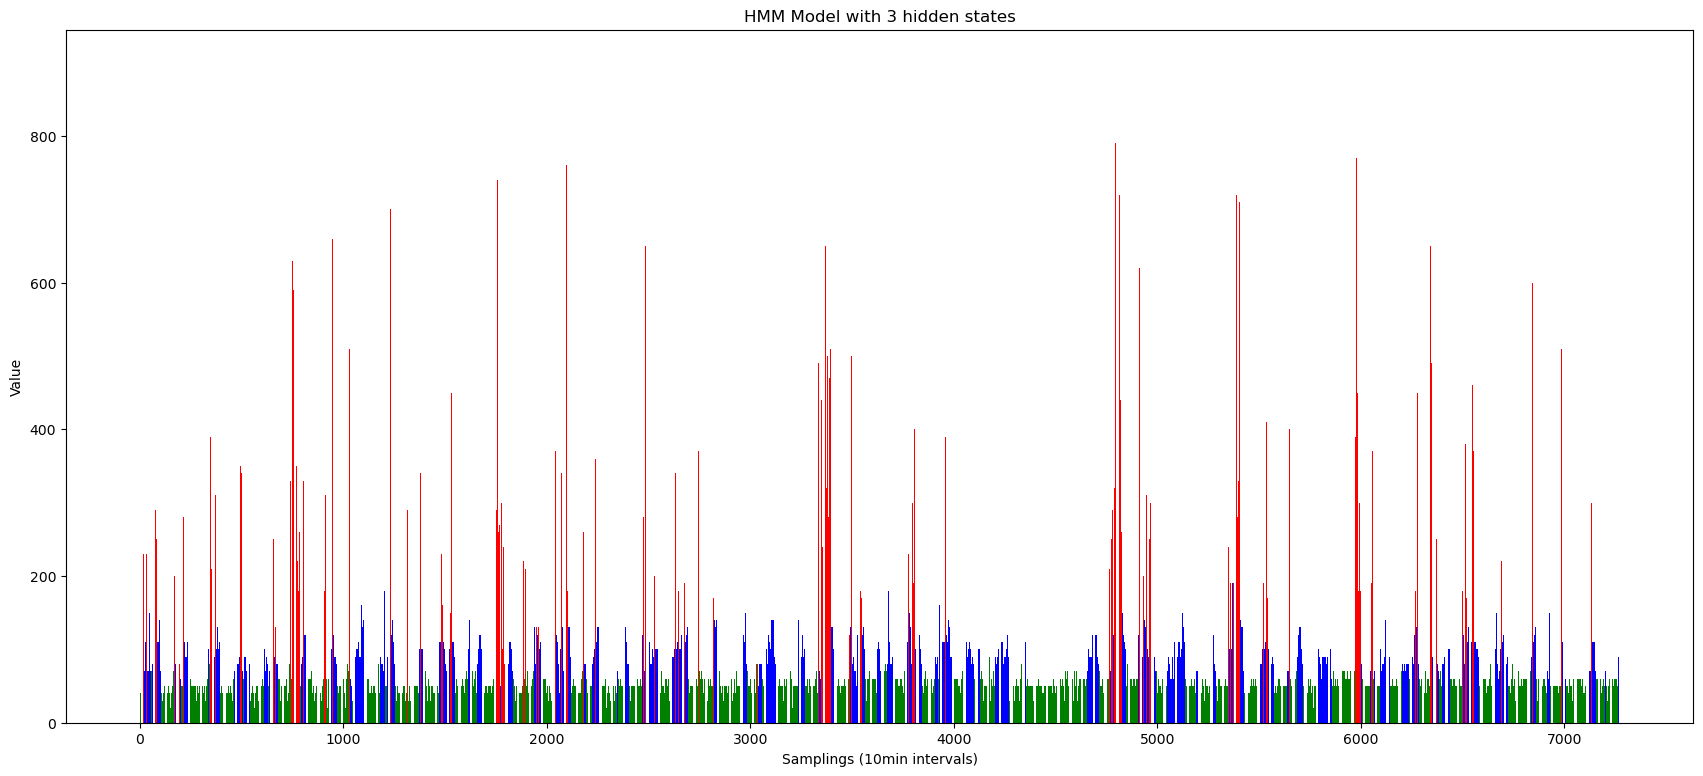

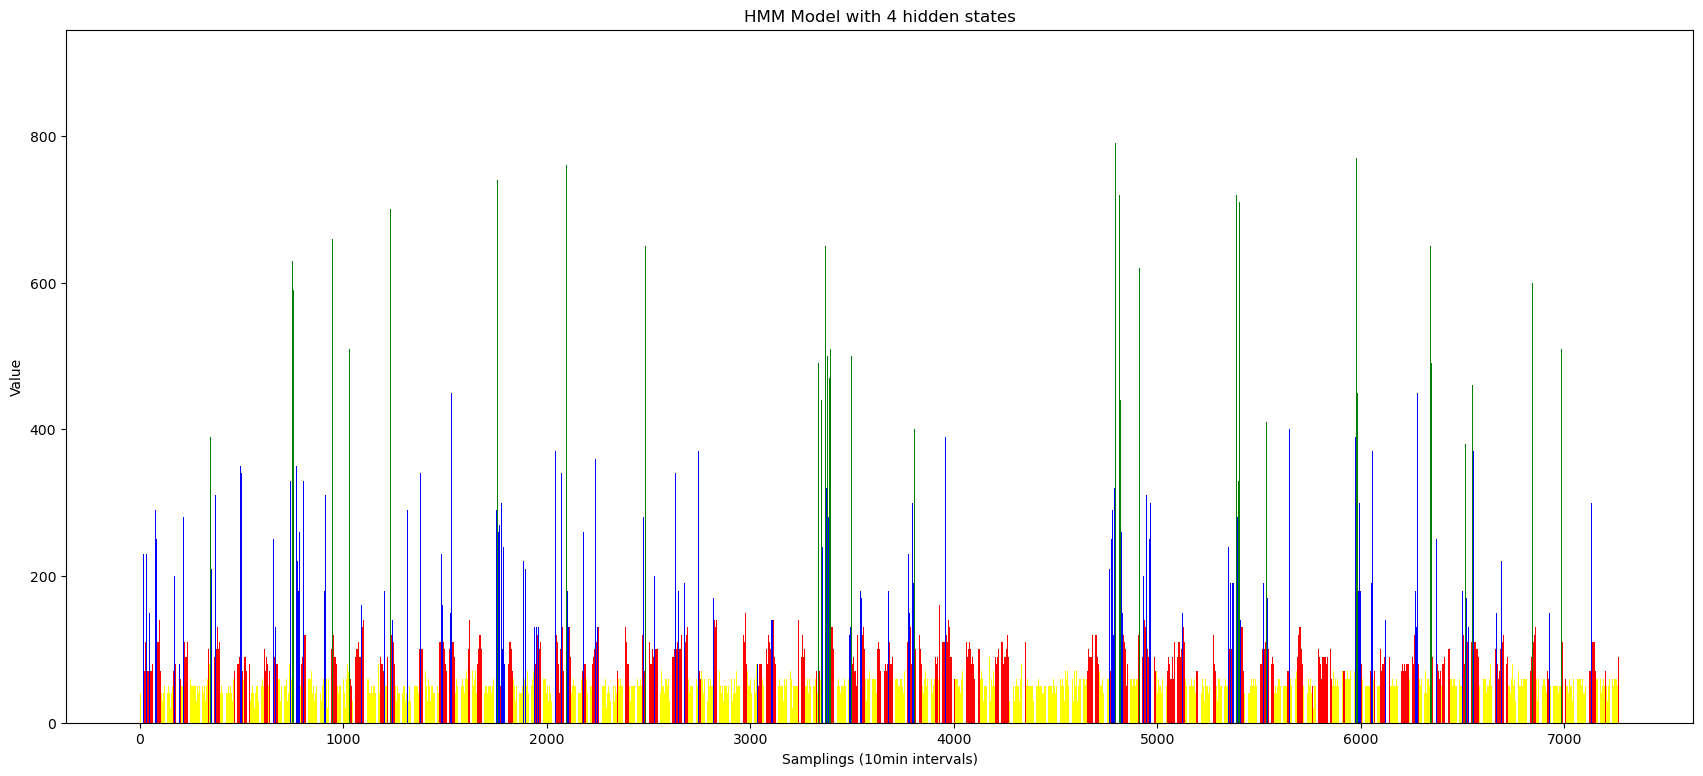

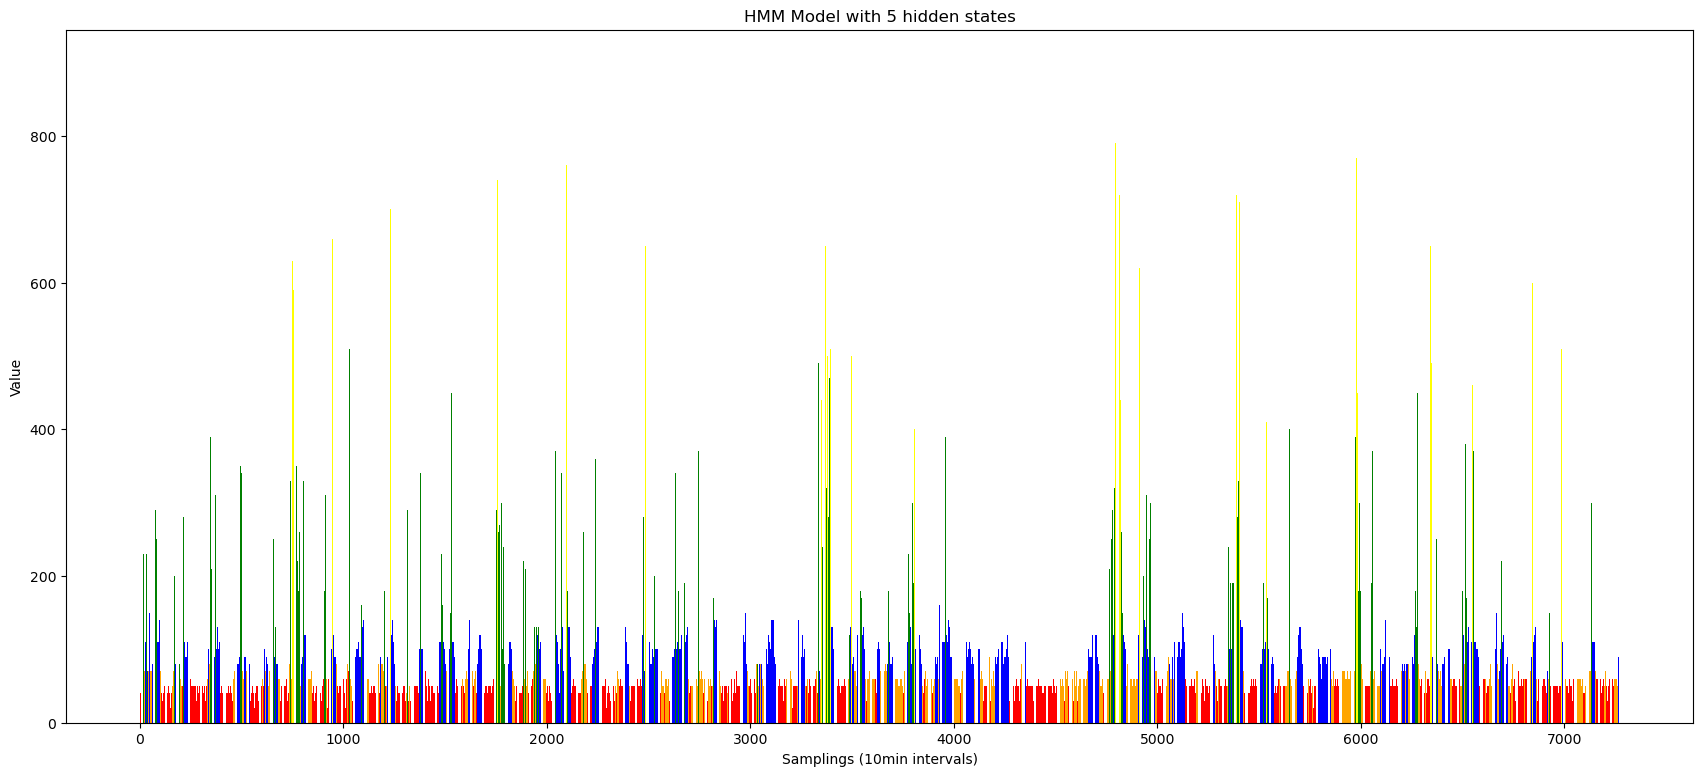

In [4]:
for i in range(2, 6):
    train_and_plot_single(
        visible_sequence_train=train_set_app, 
        visible_sequence_test=validation_set_app,
        n_components=i
    )

### Model selection

In [14]:
train = []
validation = []
for i in range(1, 20):
    _, model = train_and_plot_single(
        visible_sequence_train=train_set_app, 
        visible_sequence_test=validation_set_app,
        n_components=i,
        plot=False
    )
    train.append(model.score(train_set_app, lengths = [len(train_set_app) - 1] ))
    validation.append(model.score(validation_set_app, lengths  = [len(train_set_app) - 1] ))


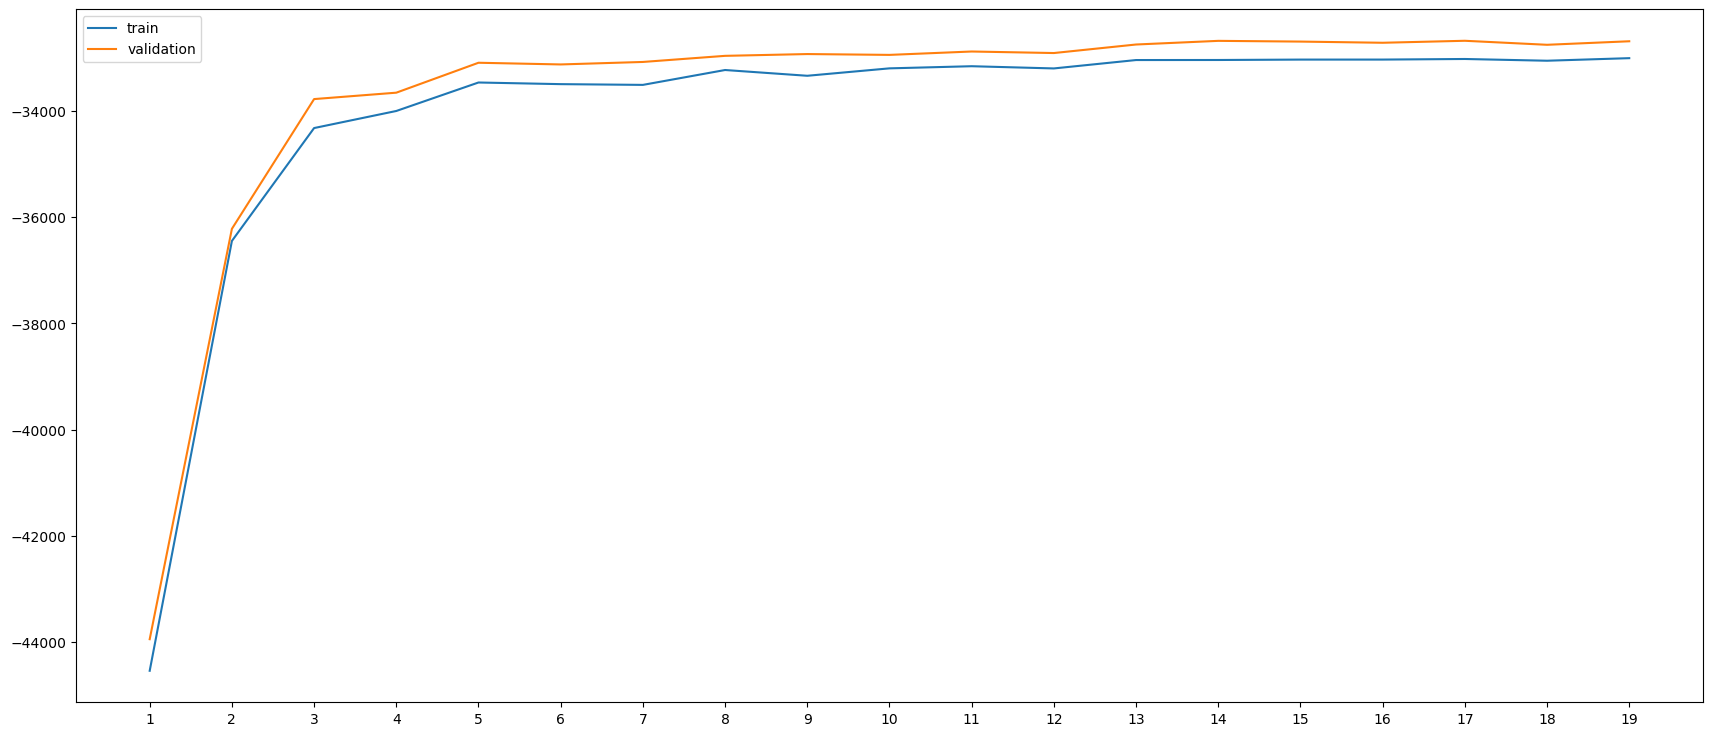

In [45]:
# plot the train and validation scores
plt.subplots(figsize=(21, 9))
plt.plot(range(1, len(train)+1), train, label="train")
plt.plot(range(1, len(train)+1), validation, label="validation")
plt.xticks(range(1, len(train)+1))
plt.legend()
plt.show()

# Lights dataset

Training and plot the model

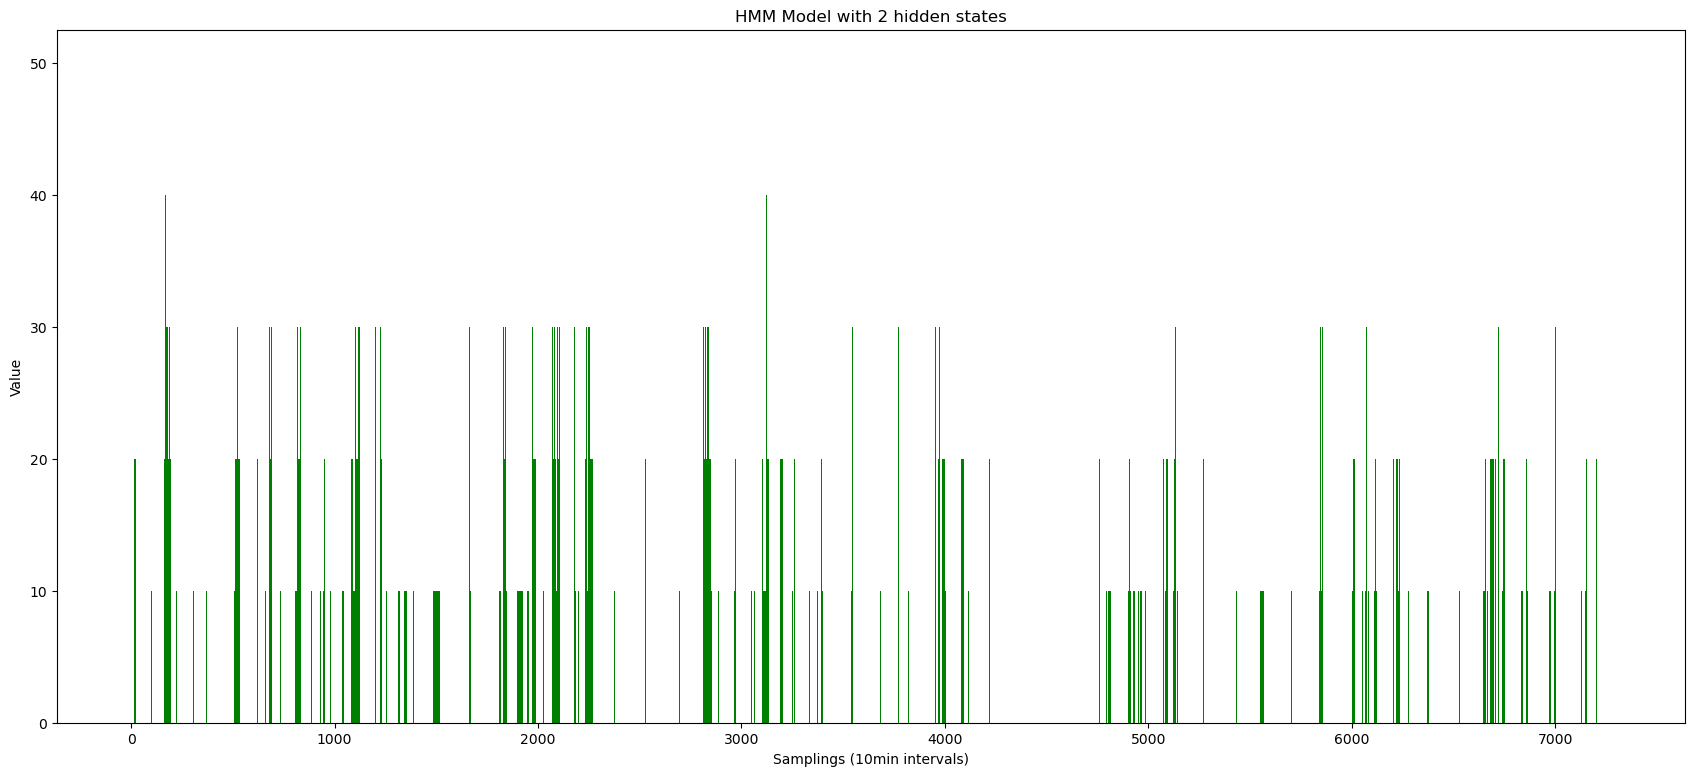

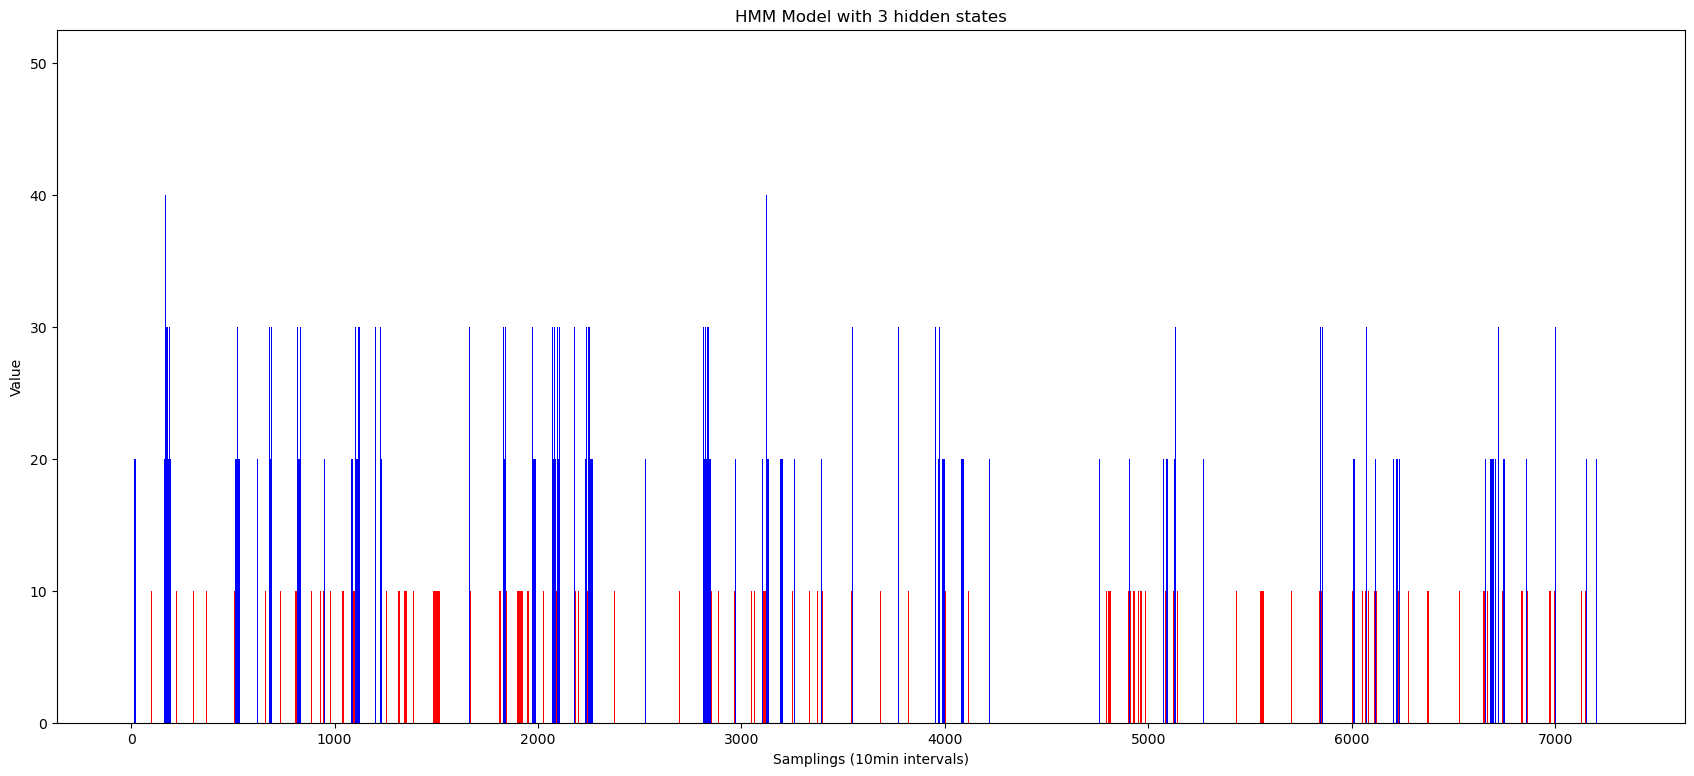

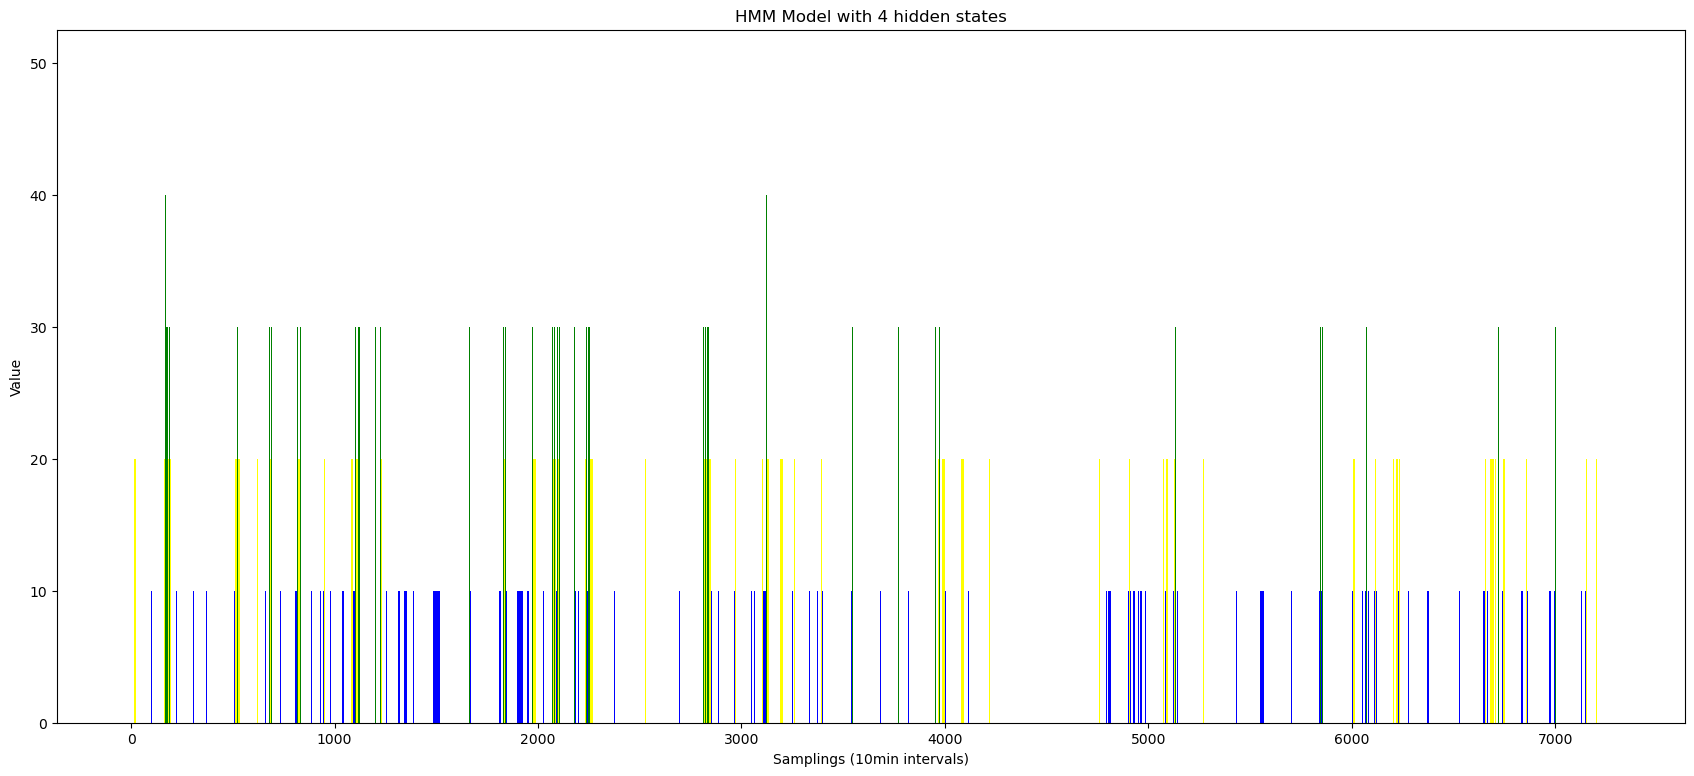

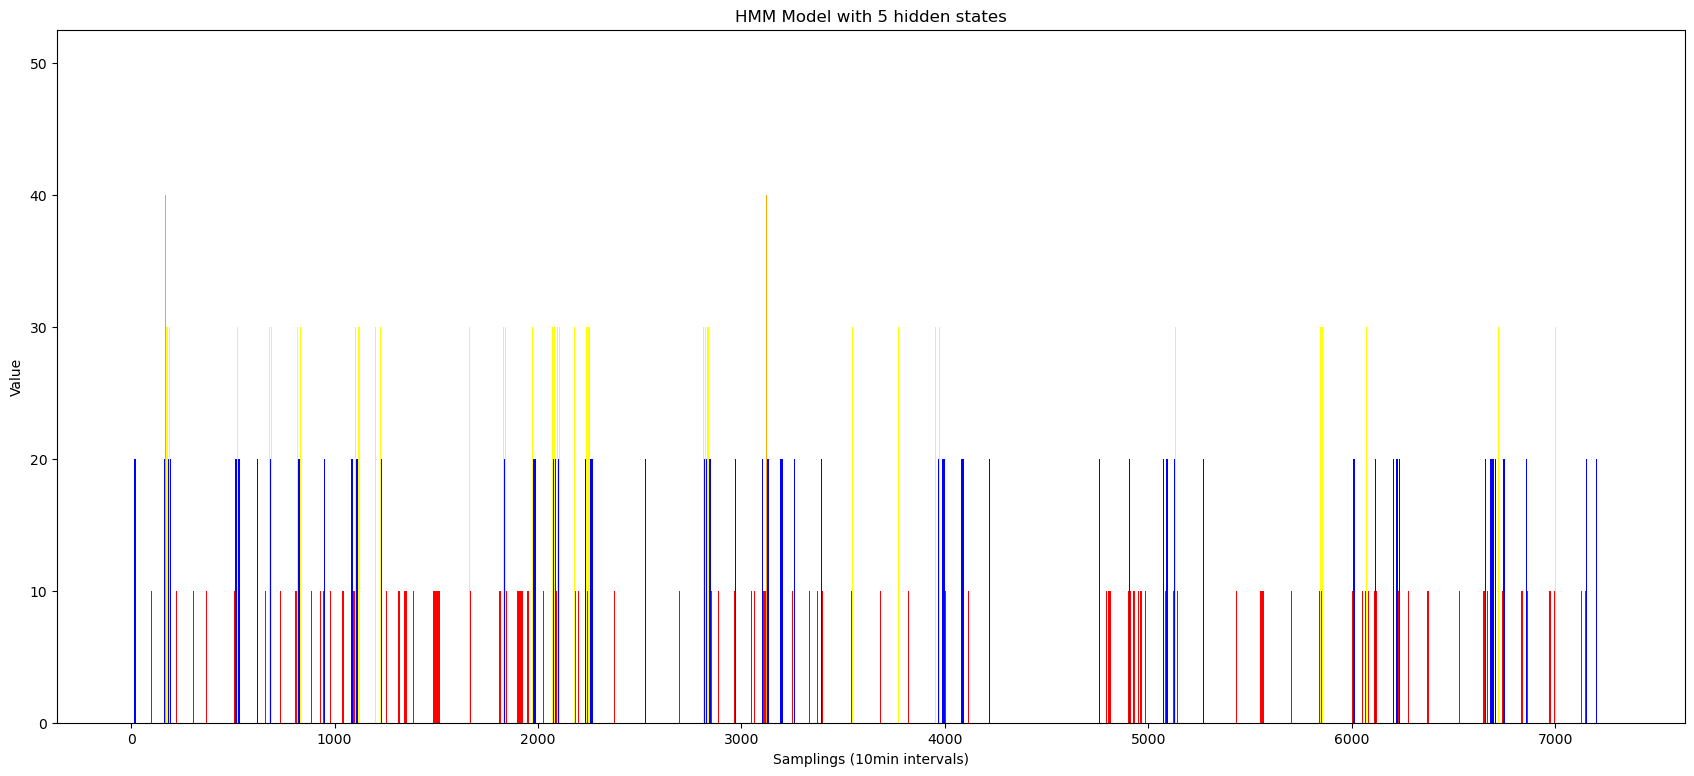

In [7]:
for i in range(2, 6):
    _, model = train_and_plot_single(
        visible_sequence_train=train_set_light, 
        visible_sequence_test=validation_set_light,
        n_components=i
    )

## Model performance


In [8]:
train = []
validation = []
for i in range(1, 9):
    _, model = train_and_plot_single(
        visible_sequence_train=train_set_light, 
        visible_sequence_test=validation_set_light,
        n_components=i,
        plot=False
    )
    train.append(model.score(train_set_light, lengths = [len(train_set_light) - 1] ))
    validation.append(model.score(validation_set_light, lengths  = [len(validation_set_light) - 1] ))

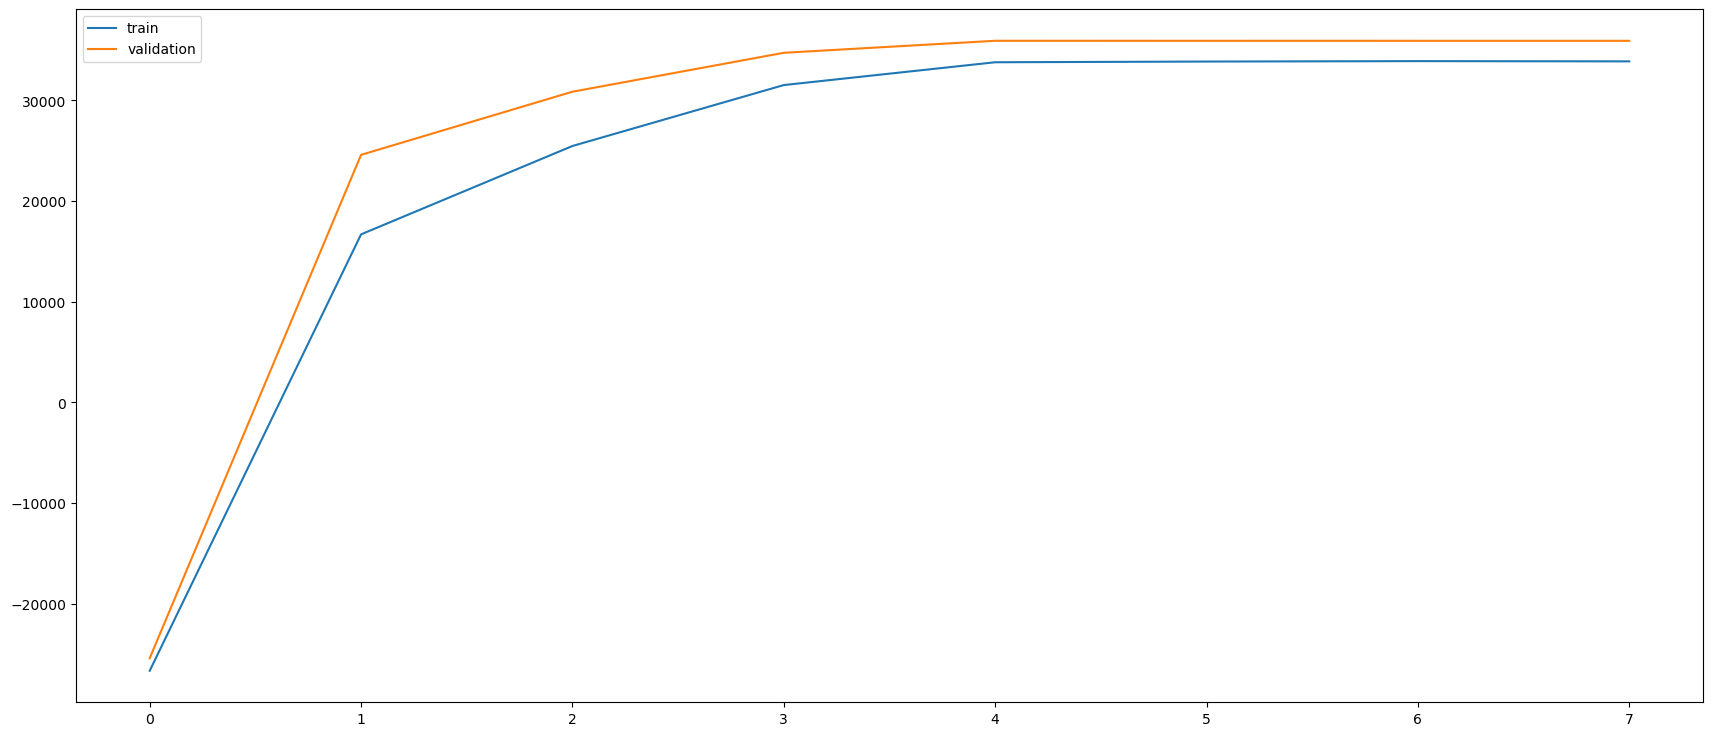

In [9]:
# plot the train and validation scores
plt.subplots(figsize=(21, 9))
plt.plot(range(1, len(train)+1), train, label="train")
plt.plot(range(1, len(train)+1), validation, label="validation")
plt.xticks(range(1, len(train)+1))
plt.legend()
plt.show()

# Double emission distribution

Let's join again the two features of the timeseries in a single matrix in order to train an HMM with two emission distributions.

In [10]:
# join the two features in a single matrix

train_set_mixed = np.concatenate((train_set_app, train_set_light), axis=1)
test_set_mixed = np.concatenate((test_set_app, test_set_light), axis=1)

test_set_mixed.shape

(5190, 2)

The following is a function that trains the HMM with two features and the plots two different barplot, one for each feature.

In [11]:
def train_and_plot_double(
    visible_sequence_train,
    visible_sequence_test, 
    n_components : int = 2, 
    ) -> np.array:
    
    # create and train an HMM model
    model = hmm.GaussianHMM(n_components=n_components)
    model.fit(visible_sequence_train)

    # predict the most likely sequence of internal hidden state
    prob, hidden_sequence = model.decode(visible_sequence_test, algorithm='viterbi')

    # transform the numpy matrix into a 1-D list
    visible_sequence_test_0 = [i[0] for i in visible_sequence_test]
    visible_sequence_test_1 = [i[1] for i in visible_sequence_test]

    colors_map = {0: "red", 1: "green", 2: "blue", 3: "yellow", 4: "orange", 5: "purple", 6: "pink", 7: "brown", 8: "gray", 9: "olive", 10: "cyan"}

    # map the hidden states to colors
    colors_sequence = [colors_map[i] for i in hidden_sequence]

    plt.subplots(figsize=(21, 9))
    plt.xlabel('Samplings (10min intervals)')
    plt.ylabel('Value')
    plt.title(f'HMM Model with {n_components} hidden states. First feature.')
    plt.bar(
        x = [i for i in range(len(visible_sequence_test_0))],
        height = visible_sequence_test_0,
        color = colors_sequence
    )
    plt.show()
    
    plt.subplots(figsize=(21, 9))
    plt.xlabel('Samplings (10min intervals)')
    plt.ylabel('Value')
    plt.title(f'HMM Model with {n_components} hidden states. Second feature.')
    plt.bar(
        x = [i for i in range(len(visible_sequence_test_1))],
        height = visible_sequence_test_1,
        color = colors_sequence
    )
    plt.show()
 

    return hidden_sequence, model

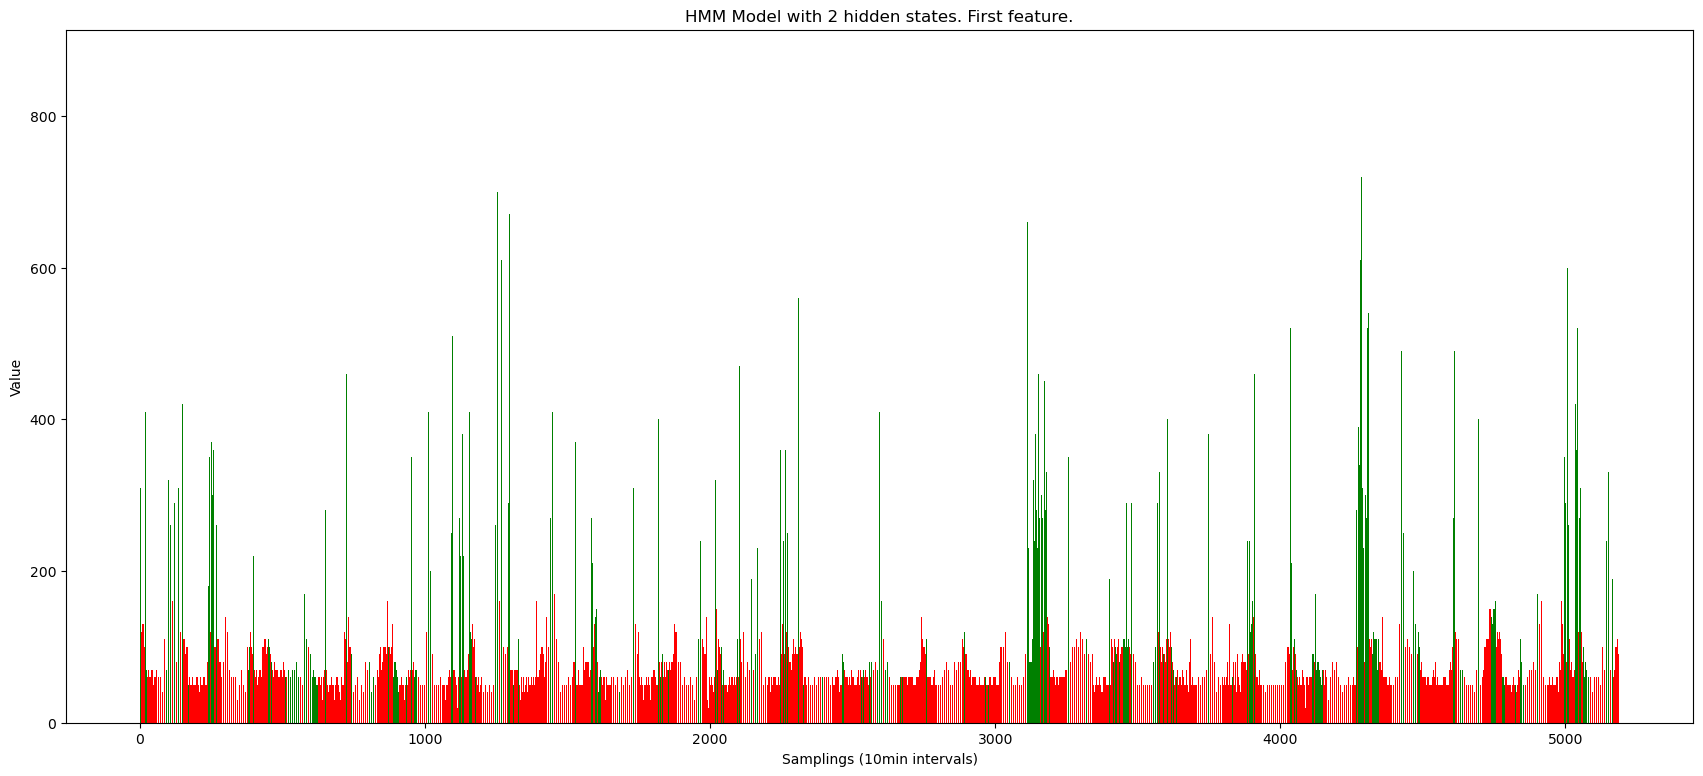

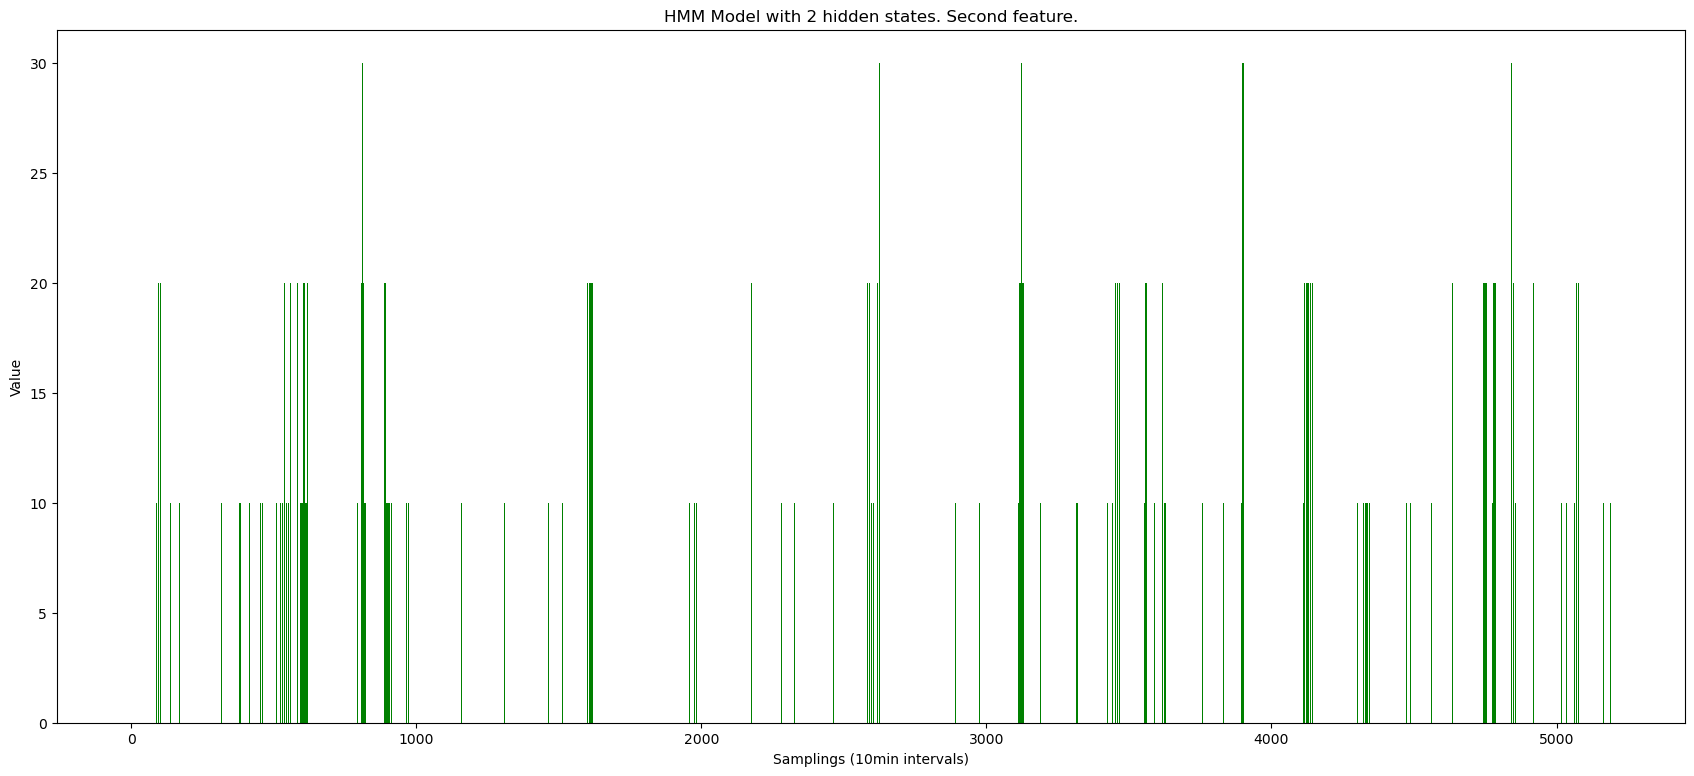

In [12]:

hidden_sequence, model = train_and_plot_double(
    visible_sequence_train=train_set_mixed,
    visible_sequence_test=test_set_mixed,
    n_components=2
)